In [1]:
from IPython.display import display, HTML
display(HTML("""
<style>
div.container{width:90% !important;}
div.cell.code_cell.rendered{width:100%;}
div.input_prompt{padding:0px;}
div.CodeMirror {font-family:Consolas; font-size:12pt;}
div.text_cell_render.rendered_html{font-size:12pt;}
div.output {font-size:12pt; font-weight:bold;}
div.input {font-family:Consolas; font-size:12pt;}
div.prompt {min-width:70px;}
div#toc-wrapper{padding-top:120px;}
div.text_cell_render ul li{font-size:12pt;padding:5px;}
table.dataframe{font-size:12px;}
</style>
"""))

<b><font size="6" color="#009e84"> ch04. RNN</font></b>

- 데이터의 순서가 중요하거나, 시계열 데이터일 경우
- 활용분야 : 번역, 음성인식, 주가예측, 농수산물 가격예측

# 1. 문맥을 이용하여 모델만들기

In [4]:
text = '''경마장에 있는 말이 뛰고 있다
그의 말이 법이다
가는 말이 고와야 오는 말이 곱다'''
text1 = '겨울이 오는 날' 

In [6]:
from keras_preprocessing.text import Tokenizer

t = Tokenizer()
t.fit_on_texts([text, text1]) # 반드시 리스트로 넣어야함
encoded = t.texts_to_sequences([text, text1])
print(encoded)
print(t.word_index) # 제일 많이 오는 단어가 1(말이)

[[3, 4, 1, 5, 6, 7, 1, 8, 9, 1, 10, 2, 1, 11], [12, 2, 13]]
{'말이': 1, '오는': 2, '경마장에': 3, '있는': 4, '뛰고': 5, '있다': 6, '그의': 7, '법이다': 8, '가는': 9, '고와야': 10, '곱다': 11, '겨울이': 12, '날': 13}


In [7]:
t.texts_to_sequences(['경마장에 있는 말이 뛰고']) # 한문장이어도 무조건 리스트로 넣어야함. 그리고 2차원으로 출력.

[[3, 4, 1, 5]]

In [8]:
t.texts_to_sequences(['경마장에 있는 말이 뛰고'])[0] # 1차원으로 보고싶으면 이렇게

[3, 4, 1, 5]

In [10]:
t.texts_to_sequences(['경마장에 있는 말이 뛴다'])[0] # 학습한 말 외에 물어보면 무시

[3, 4, 1]

In [ ]:
text = '''경마장에 있는 말이 뛰고 있다
그의 말이 법이다
가는 말이 고와야 오는 말이 곱다'''

In [11]:
# text1 없이 다시 학습

t = Tokenizer()
t.fit_on_texts([text])
encoded = t.texts_to_sequences([text])[0]
print(encoded)
print(t.word_index)

[2, 3, 1, 4, 5, 6, 1, 7, 8, 1, 9, 10, 1, 11]
{'말이': 1, '경마장에': 2, '있는': 3, '뛰고': 4, '있다': 5, '그의': 6, '법이다': 7, '가는': 8, '고와야': 9, '오는': 10, '곱다': 11}


In [12]:
for key, value in t.word_index.items(): # 딕셔너리 for문 돌릴때는 items 사용
    print(key, value)

말이 1
경마장에 2
있는 3
뛰고 4
있다 5
그의 6
법이다 7
가는 8
고와야 9
오는 10
곱다 11


In [18]:
# text를 학습시키기 위해, ['경마장에 있는'(2,3), '경마장에 있는 말이'(2,3,1),...] 문장을 슬라이싱 해야함

sequences = []
for line in text.split('\n'):
    encoded = t.texts_to_sequences([line])[0]
    print('원문장 :', line, 'encoded된 문장 :', encoded)
    for i in range(0, len(encoded)-1): # 시작 index 2,3 / 2,3,1 / ... / 4,5  이렇게 학습해야하니까 시작 인덱스는 4까지만 와야함
        for j in range(i+2, len(encoded)+1): # 끝나는 index. 데이터가 2개는 와야하기 때문에 [i:j]이렇게 슬라이싱 하려면 i+2여야하는것. 그리고 j에는 5까지 들어와야하니까 +1해주는것
            # print(encoded[i:j])
            sequences.append(encoded[i:j])
print('sequences와 해석')
for sequence in sequences:
    # print(sequence)
    for word_seq in sequence:
        for key, value in t.word_index.items():
            if word_seq==value:
                print('{}:{}'.format(word_seq, key), end=' ')
                break
    print() # 개행

원문장 : 경마장에 있는 말이 뛰고 있다 encoded된 문장 : [2, 3, 1, 4, 5]
원문장 : 그의 말이 법이다 encoded된 문장 : [6, 1, 7]
원문장 : 가는 말이 고와야 오는 말이 곱다 encoded된 문장 : [8, 1, 9, 10, 1, 11]
sequences와 해석
2:경마장에 3:있는 
2:경마장에 3:있는 1:말이 
2:경마장에 3:있는 1:말이 4:뛰고 
2:경마장에 3:있는 1:말이 4:뛰고 5:있다 
3:있는 1:말이 
3:있는 1:말이 4:뛰고 
3:있는 1:말이 4:뛰고 5:있다 
1:말이 4:뛰고 
1:말이 4:뛰고 5:있다 
4:뛰고 5:있다 
6:그의 1:말이 
6:그의 1:말이 7:법이다 
1:말이 7:법이다 
8:가는 1:말이 
8:가는 1:말이 9:고와야 
8:가는 1:말이 9:고와야 10:오는 
8:가는 1:말이 9:고와야 10:오는 1:말이 
8:가는 1:말이 9:고와야 10:오는 1:말이 11:곱다 
1:말이 9:고와야 
1:말이 9:고와야 10:오는 
1:말이 9:고와야 10:오는 1:말이 
1:말이 9:고와야 10:오는 1:말이 11:곱다 
9:고와야 10:오는 
9:고와야 10:오는 1:말이 
9:고와야 10:오는 1:말이 11:곱다 
10:오는 1:말이 
10:오는 1:말이 11:곱다 
1:말이 11:곱다 


In [19]:
sequences

[[2, 3],
 [2, 3, 1],
 [2, 3, 1, 4],
 [2, 3, 1, 4, 5],
 [3, 1],
 [3, 1, 4],
 [3, 1, 4, 5],
 [1, 4],
 [1, 4, 5],
 [4, 5],
 [6, 1],
 [6, 1, 7],
 [1, 7],
 [8, 1],
 [8, 1, 9],
 [8, 1, 9, 10],
 [8, 1, 9, 10, 1],
 [8, 1, 9, 10, 1, 11],
 [1, 9],
 [1, 9, 10],
 [1, 9, 10, 1],
 [1, 9, 10, 1, 11],
 [9, 10],
 [9, 10, 1],
 [9, 10, 1, 11],
 [10, 1],
 [10, 1, 11],
 [1, 11]]

In [52]:
my_len = max([len(sequence) for sequence in sequences])

In [53]:
# sequences를 훈련가능하도록 6개(my_len : text를 sequence한것의 최대값)열로 조정

from tensorflow.keras.preprocessing.sequence import pad_sequences

paded_sequences = pad_sequences(sequences=sequences,
                              maxlen=my_len,
                              padding='pre', # padding은 작은 6개보다 작은 것을 늘리는것
                              # padding='post', # 상황에 맞게 앞에 0을 붙일지 뒤에 0을 붙일지 봐야함. 특별한 규칙은 없음
                              # truncating='pre', 지금은 필요없지만 maxlen보다 큰것을 앞에 자른다는말. 'post'는 뒤에를 자름
                              )
type(paded_sequences), paded_sequences.shape, paded_sequences

(numpy.ndarray,
 (28, 6),
 array([[ 0,  0,  0,  0,  2,  3],
        [ 0,  0,  0,  2,  3,  1],
        [ 0,  0,  2,  3,  1,  4],
        [ 0,  2,  3,  1,  4,  5],
        [ 0,  0,  0,  0,  3,  1],
        [ 0,  0,  0,  3,  1,  4],
        [ 0,  0,  3,  1,  4,  5],
        [ 0,  0,  0,  0,  1,  4],
        [ 0,  0,  0,  1,  4,  5],
        [ 0,  0,  0,  0,  4,  5],
        [ 0,  0,  0,  0,  6,  1],
        [ 0,  0,  0,  6,  1,  7],
        [ 0,  0,  0,  0,  1,  7],
        [ 0,  0,  0,  0,  8,  1],
        [ 0,  0,  0,  8,  1,  9],
        [ 0,  0,  8,  1,  9, 10],
        [ 0,  8,  1,  9, 10,  1],
        [ 8,  1,  9, 10,  1, 11],
        [ 0,  0,  0,  0,  1,  9],
        [ 0,  0,  0,  1,  9, 10],
        [ 0,  0,  1,  9, 10,  1],
        [ 0,  1,  9, 10,  1, 11],
        [ 0,  0,  0,  0,  9, 10],
        [ 0,  0,  0,  9, 10,  1],
        [ 0,  0,  9, 10,  1, 11],
        [ 0,  0,  0,  0, 10,  1],
        [ 0,  0,  0, 10,  1, 11],
        [ 0,  0,  0,  0,  1, 11]]))

In [55]:
# 독립변수(X)와 타겟변수(y)로 분리

X = paded_sequences[:, :-1]
y = paded_sequences[:, -1]
X.shape, y.shape

((28, 5), (28,))

In [56]:
# 단어 갯수
vocab_size = len(t.word_index)

# X를 임베딩작업을 할 때 input_dim
input_dim = vocab_size+1

In [57]:
# 타겟변수(y)의 원핫인코딩

from tensorflow.keras.utils import to_categorical
Y = to_categorical(y) # 학습시키고자 하는 단어수는 자동으로 들어가지만 쓰고싶다면 vocab_size+1 이라고 쓰기
Y

array([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.,

In [58]:
X.shape, Y.shape, vocab_size

((28, 5), (28, 12), 11)

In [59]:
# import
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense

# 1. 학습 모델 생성
model = Sequential()

# 2. 원핫인코딩한 희소행렬을 임베딩 벡터로 변환
model.add(Embedding(input_dim=vocab_size+1,  # 임베딩층의 입력(원핫인코딩 dim)
                    output_dim=10,           # 임베딩층의 출력
                    input_length=X.shape[1], # X가 (28,5) = X의 열수. 입력 데이터의 길이
                    ))
model.add(SimpleRNN(units=32))
model.add(Dense(units=12, activation='softmax'))
model.summary() # simple_rnn의 파라미터가 1376개인 이유 : (10*32) + (32*32) + 32

# 3. 모델 학습 설정
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# 4. 모델 학습시키기
hist = model.fit(X,Y, epochs=300, verbose=2)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 5, 10)             120       
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 32)                1376      
                                                                 
 dense_2 (Dense)             (None, 12)                396       
                                                                 
Total params: 1,892
Trainable params: 1,892
Non-trainable params: 0
_________________________________________________________________
Epoch 1/300
1/1 - 1s - loss: 2.4665 - accuracy: 0.2143 - 594ms/epoch - 594ms/step
Epoch 2/300
1/1 - 0s - loss: 2.4508 - accuracy: 0.2500 - 4ms/epoch - 4ms/step
Epoch 3/300
1/1 - 0s - loss: 2.4354 - accuracy: 0.2857 - 3ms/epoch - 3ms/step
Epoch 4/300
1/1 - 0s - loss: 2.4198 - accuracy: 0.2857 - 3ms/epoch - 3ms/step


Epoch 95/300
1/1 - 0s - loss: 1.2036 - accuracy: 0.6071 - 3ms/epoch - 3ms/step
Epoch 96/300
1/1 - 0s - loss: 1.1918 - accuracy: 0.6071 - 3ms/epoch - 3ms/step
Epoch 97/300
1/1 - 0s - loss: 1.1802 - accuracy: 0.6071 - 3ms/epoch - 3ms/step
Epoch 98/300
1/1 - 0s - loss: 1.1688 - accuracy: 0.6071 - 3ms/epoch - 3ms/step
Epoch 99/300
1/1 - 0s - loss: 1.1575 - accuracy: 0.6429 - 2ms/epoch - 2ms/step
Epoch 100/300
1/1 - 0s - loss: 1.1465 - accuracy: 0.6429 - 2ms/epoch - 2ms/step
Epoch 101/300
1/1 - 0s - loss: 1.1356 - accuracy: 0.6429 - 3ms/epoch - 3ms/step
Epoch 102/300
1/1 - 0s - loss: 1.1249 - accuracy: 0.6429 - 3ms/epoch - 3ms/step
Epoch 103/300
1/1 - 0s - loss: 1.1144 - accuracy: 0.6429 - 3ms/epoch - 3ms/step
Epoch 104/300
1/1 - 0s - loss: 1.1040 - accuracy: 0.7143 - 4ms/epoch - 4ms/step
Epoch 105/300
1/1 - 0s - loss: 1.0939 - accuracy: 0.7143 - 2ms/epoch - 2ms/step
Epoch 106/300
1/1 - 0s - loss: 1.0838 - accuracy: 0.7143 - 2ms/epoch - 2ms/step
Epoch 107/300
1/1 - 0s - loss: 1.0740 - accur

Epoch 198/300
1/1 - 0s - loss: 0.5339 - accuracy: 0.8571 - 3ms/epoch - 3ms/step
Epoch 199/300
1/1 - 0s - loss: 0.5301 - accuracy: 0.8571 - 2ms/epoch - 2ms/step
Epoch 200/300
1/1 - 0s - loss: 0.5265 - accuracy: 0.8571 - 2ms/epoch - 2ms/step
Epoch 201/300
1/1 - 0s - loss: 0.5228 - accuracy: 0.8929 - 2ms/epoch - 2ms/step
Epoch 202/300
1/1 - 0s - loss: 0.5192 - accuracy: 0.8929 - 3ms/epoch - 3ms/step
Epoch 203/300
1/1 - 0s - loss: 0.5156 - accuracy: 0.8929 - 2ms/epoch - 2ms/step
Epoch 204/300
1/1 - 0s - loss: 0.5121 - accuracy: 0.8929 - 2ms/epoch - 2ms/step
Epoch 205/300
1/1 - 0s - loss: 0.5086 - accuracy: 0.8929 - 2ms/epoch - 2ms/step
Epoch 206/300
1/1 - 0s - loss: 0.5051 - accuracy: 0.8929 - 3ms/epoch - 3ms/step
Epoch 207/300
1/1 - 0s - loss: 0.5016 - accuracy: 0.8929 - 2ms/epoch - 2ms/step
Epoch 208/300
1/1 - 0s - loss: 0.4982 - accuracy: 0.8929 - 3ms/epoch - 3ms/step
Epoch 209/300
1/1 - 0s - loss: 0.4949 - accuracy: 0.8929 - 2ms/epoch - 2ms/step
Epoch 210/300
1/1 - 0s - loss: 0.4915 - 

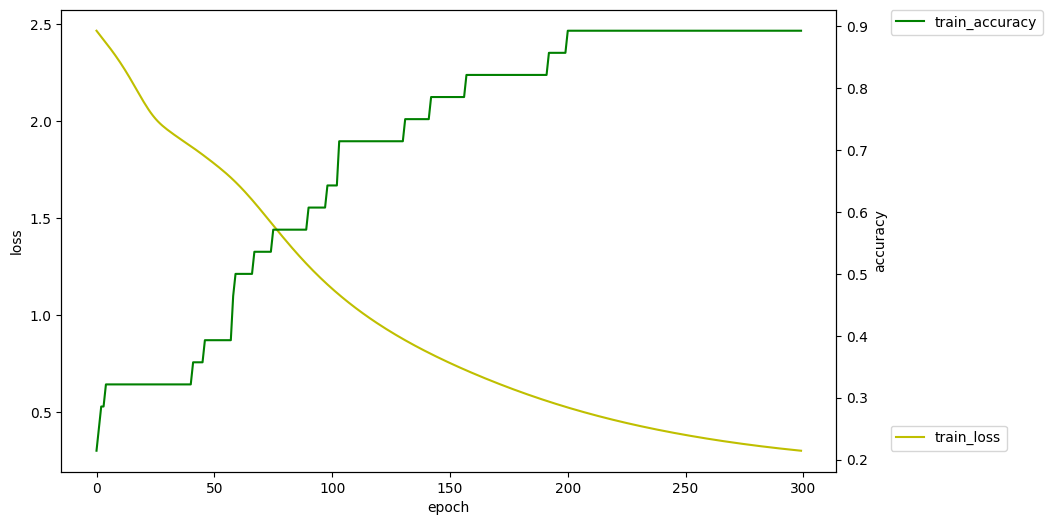

In [60]:
# 5. 모델 평가 / 학습과정 표시하기
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots(figsize=(10,6))
loss_ax.plot(hist.history['loss'], 'y', label='train_loss')

acc_ax = loss_ax.twinx() # loss_ax와 x축을 공유하는 acc_ax생성
acc_ax.plot(hist.history['accuracy'], 'g', label='train_accuracy')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')

loss_ax.legend(bbox_to_anchor=(1.07, 0.1), loc=2, borderaxespad=0.)
acc_ax.legend(bbox_to_anchor=(1.07, 1), loc=2, borderaxespad=0.)
plt.show()

In [63]:
# 6. 모델 사용하기(경마장에 → 있는)

encoded = t.texts_to_sequences(['경마장에'])[0]
input_data = pad_sequences([encoded], maxlen=5, padding='pre')
result = model.predict(input_data, verbose=0).argmax()
print('모델이 예측 결과 :', result)
for key, value in t.word_index.items():
    if value==result:
        print('예측한 단어 :', key)
        break

모델이 예측 결과 : 3
예측한 단어 : 있는


In [64]:
encoded = t.texts_to_sequences(['겨울은'])[0]
input_data = pad_sequences([encoded], maxlen=5, padding='pre')
input_data

array([[0, 0, 0, 0, 0]])

In [67]:
# 6. 모델 사용하기(사용자로부터 입력받은 문자 → ?)

word = input('입력단어는 ?')
encoded = t.texts_to_sequences([word])[0]
input_data = pad_sequences([encoded], maxlen=5, padding='pre')
result = model.predict(input_data, verbose=0).argmax()
print('모델 예측 결과 :', result)
for key, value in t.word_index.items():
    if value==result:
        print('예측한 단어 :', key)
        break

입력단어는 ?겨울은
모델 예측 결과 : 11
예측한 단어 : 곱다


# 2. 다음 문맥 예측해보기

In [80]:
# '경마장에' 이후 단어 4개의 문맥을 만들어줘 

def sentence_generation(model, current_word, n):
    print('입력된 단어 :', current_word)
    for i in range(1, n+1):
        encoded = t.texts_to_sequences([current_word])
        input_data = pad_sequences(encoded, maxlen=my_len-1, padding='pre')
        result = model.predict(input_data, verbose=0).argmax()
        for word, index in t.word_index.items():
            if result == index:
                print('{}번째 예측 {} : {}'.format(i, result, word))
                current_word = current_word + ' ' + word
                break # 안쪽 for문 빠져나가기
    print(current_word)

In [81]:
sentence_generation(model, '경마장에', 4)

입력된 단어 : 경마장에
1번째 예측 3 : 있는
2번째 예측 1 : 말이
3번째 예측 4 : 뛰고
4번째 예측 5 : 있다
경마장에 있는 말이 뛰고 있다
